# Dataset

In [1]:
import zipfile

!wget https://chitanka.info/text/4618-frankenshtajn.txt.zip

path = "4618-frankenshtajn.txt.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(".")
    
!mv "Mary-Shelley -  - . Frankenshtajn - 4618.txt" "dataset.txt"

!rm $path


--2024-09-23 08:34:13--  https://chitanka.info/text/4618-frankenshtajn.txt.zip
Resolving chitanka.info (chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.97.2, ...
Connecting to chitanka.info (chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename= [following]
--2024-09-23 08:34:13--  https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename=
Resolving m3.chitanka.info (m3.chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.96.2, ...
Connecting to m3.chitanka.info (m3.chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip [following]
--2024-09-23 08:34:14--  https://m3.chitanka.info/cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip
Reusing existing connection to [m3.chitanka.info]:443.
HTTP request sent, awaiting respon

In [2]:
with open("dataset.txt", "r") as f:
    text = f.read()

# Vocabulary

In [3]:
unique_chars = set(text)
sorted_chars = sorted(unique_chars)
sorted_chars
"".join(sorted_chars)

'\t\n !$()*,-./0123456789:;=?DIMNVX[]_abcdefghijkmnoprstuvx«»АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЮЯабвгдежзийклмнопрстуфхцчшщъьюя–—“„…\ufeff'

# Tokenizer

In [4]:
encoding = { c: i for i, c in enumerate(sorted_chars) }

def encode(text: str):
    return [encoding[c] for c in text]

def test_encode():
    test_text = "франкейщайн!"
    test_encoding = encode(test_text)
    assert test_encoding[0] == encoding[test_text[0]]
    assert test_encoding[1] == encoding[test_text[1]]
    
# test_encode()

decoding = { i: c for i, c in enumerate(sorted_chars) }

test_text = "франкейщайн!"
test_encoding = encode(test_text)

def decode(arr):
    return "".join([decoding[t] for t in arr])

def test_decode():
    test_text = "франкейщайн!"
    assert decode(encode(test_text)) == test_text
    
# test_decode()

In [5]:
import torch

data = torch.tensor(encode(text))

data

tensor([120,   0,  69,  ...,  13,   1,   1])

In [6]:
train_data_size = round(len(data) * 0.9)

train_data = data[:train_data_size]

train_data

tensor([120,   0,  69,  ..., 102,  95,  99])

In [7]:
val_data = data[train_data_size:]

val_data

tensor([103,  99,   2,  ...,  13,   1,   1])

# Model input and output (output = input[last + 1])

In [8]:
context_length = 8

train_data[:context_length+1]

tensor([120,   0,  69,  90, 101,  93,   2,  81,  90])

In [9]:
model_input = train_data[:context_length]

model_input

tensor([120,   0,  69,  90, 101,  93,   2,  81])

In [10]:
decode(model_input.numpy().tolist())

'\ufeff\tМери Ш'

In [11]:
model_output = train_data[1:context_length+1]

model_output[-1]

tensor(90)

In [12]:
decode(model_output.numpy().tolist())[-1]

'е'

# Batch

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_batch(split: str, batch_size: int, context_length: int):
    batch_data = train_data if split == "train" else val_data
    ix = torch.randint(len(batch_data) - context_length, (batch_size,))

    x = torch.stack([batch_data[i:i+context_length] for i in ix])
        
    y = torch.stack([batch_data[i+1:i+context_length+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    
    return x, y

# Log loss

In [14]:
@torch.no_grad()
def estimate_loss(model, iterations, batch_size, context_length):
    estimation = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(iterations)
        for k in range(iterations):
            X, Y = get_batch(split, batch_size, context_length)
            X, Y = X.to(device), Y.to(device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        estimation[split] = losses.mean()
    model.train()
    return estimation

# Bigram model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset

class BigramModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx
    
m = BigramModel(vocabulary_size)

model = m.to(device)

idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=100)[0].tolist()

print(decode(generated)) # ~ random generation, model not trained

	1УХш?г(„гvоМ*Н*ьf„sbоКАЖт;БтbОцDвbДб(Б8АНЯ3–ФX3—ЛШvя„л(
ugъХщXпinЕГЛГ*ъЕВeФ]cn]хгшгюXп[ХУiугvг=_юvЦГ


# Bigram model training

In [16]:
def train_model(max_iterations=10000, iterations_interval=100, eval_iterations=50, batch_size=32, learning_rate=1e-3, model=model, context_length=8):
    train_losses = []
    val_losses = []
    steps = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for iteration in range(max_iterations):
        if iteration % iterations_interval == 0:
            losses = estimate_loss(model, eval_iterations, batch_size, context_length)
            print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            steps.append(iteration)
            
        xb, yb = get_batch("train", batch_size, context_length)
        
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
    return train_losses, val_losses, steps

step 0: train loss 5.1618, val loss 5.1782
step 100: train loss 5.0251, val loss 5.0323
step 200: train loss 4.9145, val loss 4.9067
step 300: train loss 4.7772, val loss 4.7731
step 400: train loss 4.6465, val loss 4.6704
step 500: train loss 4.5393, val loss 4.5577
step 600: train loss 4.4225, val loss 4.4285
step 700: train loss 4.3122, val loss 4.3187
step 800: train loss 4.2213, val loss 4.2067
step 900: train loss 4.0958, val loss 4.0933
step 1000: train loss 4.0072, val loss 4.0218
step 1100: train loss 3.9274, val loss 3.9322
step 1200: train loss 3.8250, val loss 3.8361
step 1300: train loss 3.7497, val loss 3.7808
step 1400: train loss 3.6783, val loss 3.6732
step 1500: train loss 3.6074, val loss 3.5779
step 1600: train loss 3.5302, val loss 3.5160
step 1700: train loss 3.4573, val loss 3.4641
step 1800: train loss 3.3991, val loss 3.4005
step 1900: train loss 3.3501, val loss 3.3334
step 2000: train loss 3.2790, val loss 3.2791
step 2100: train loss 3.2228, val loss 3.2218


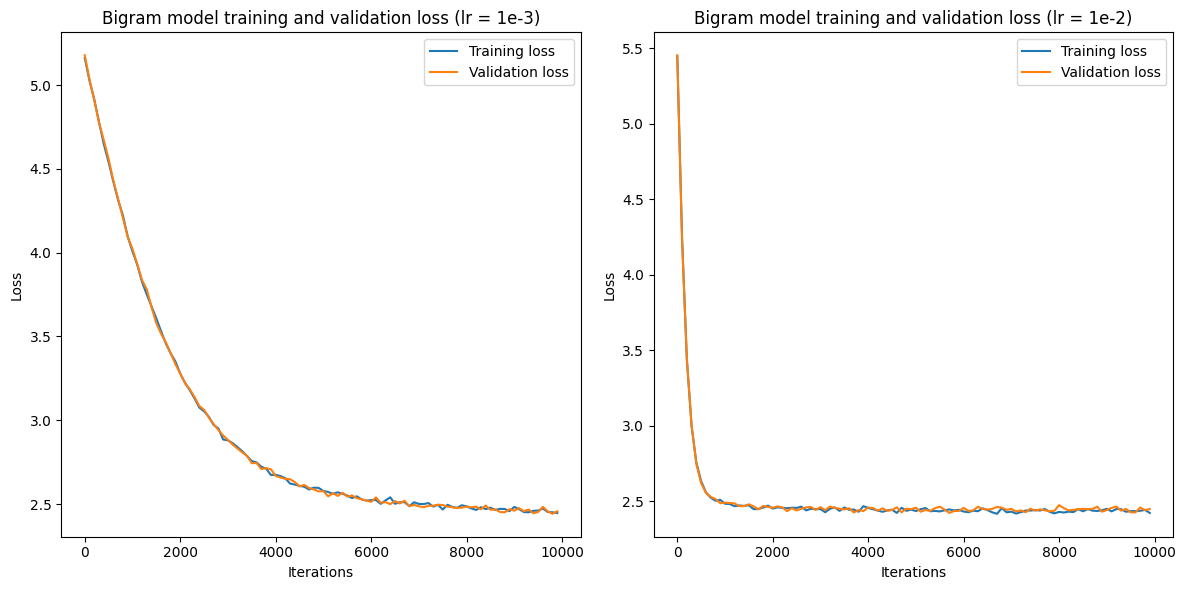

In [17]:
import matplotlib.pyplot as plt

train_losses, val_losses, steps = train_model(model=model)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(steps, train_losses, label="Training loss")
ax1.plot(steps, val_losses, label="Validation loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Bigram model training and validation loss (lr = 1e-3)")
ax1.legend()

m = BigramModel(vocabulary_size)

model = m.to(device)

train_losses, val_losses, steps = train_model(learning_rate=1e-2, model=model)

ax2.plot(steps, train_losses, label="Training loss")
ax2.plot(steps, val_losses, label="Validation loss")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("Bigram model training and validation loss (lr = 1e-2)")
ax2.legend()
plt.tight_layout()
plt.show()

In [18]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=300)[0].tolist()

print(decode(generated))

	А с нисправемлкобеста бей плесе е бе ичо Вари одеубяка т. тнавозоясие ито-съва мробли ки, бе спода. весънох Ка рпкъла въота _, Кой увасе къва, иетващома чиях ня ода оводиза вс мешанерезатетнатичичи на стеливазачеси звънежи врк съга обашуста, нате потока седн? по мнотизаръри скохалели вли осн д е бя 


# Self-attention

Current tokens should get information only from previous tokens (not future ones)

Inefficient way of computing

In [19]:
import torch

batch, time, channel = 4, 8, 2
x = torch.randn(batch, time, channel)
x.shape

torch.Size([4, 8, 2])

In [20]:
 # x[b, t] = mean_{i <= t} x[b, i]
 
x_bag_of_words = torch.zeros(batch, time, channel)

for b in range(batch):
    for t in range(time):
        x_previous = x[b, :t+1] # (time, channel)
        x_bag_of_words[b, t] = torch.mean(x_previous, 0)
        
# x[0] equals x_bag_of_words[0] but x[1] does not equal x_bag_of_words[1]
# because x_bag_of_words[1] is the average of [x0] and x[1]

In [21]:
x[0]

tensor([[-0.9796,  2.5210],
        [ 0.2241,  1.0760],
        [ 0.8168,  1.5393],
        [ 0.8766, -0.7037],
        [ 0.1434,  0.6903],
        [-0.2933,  0.3635],
        [-0.7517, -1.9126],
        [ 0.0594, -0.5796]])

In [22]:
x_bag_of_words[0]

tensor([[-0.9796,  2.5210],
        [-0.3777,  1.7985],
        [ 0.0204,  1.7121],
        [ 0.2345,  1.1081],
        [ 0.2163,  1.0246],
        [ 0.1313,  0.9144],
        [ 0.0052,  0.5105],
        [ 0.0120,  0.3743]])

Computing using matrix multiplication (weighted aggregation)

In [23]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # [[1., 0., 0.], [1., 1., 0.], [1., 1., 1.]]
a = a / torch.sum(a, 1, keepdim=True) # dividing by [[1.], [2.], [3.]], a becomes [[1., 0., 0.], [0.5, 0.5, 0.], [0.33, 0.33, 0.33]]
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# again each row in C is the average of the previous

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [24]:
weighted_aggregation = torch.tril(torch.ones(time, time))
weighted_aggregation = weighted_aggregation / weighted_aggregation.sum(1, keepdim=True)

x_bag_of_words_wei = weighted_aggregation @ x # (batch, time, time) @ (batch, time, channel) ----> (batch, time, channel)
torch.allclose(x_bag_of_words, x_bag_of_words_wei)

True

Computing using softmax (normalization)

In [25]:
import torch.nn.functional as F

tril = torch.tril(torch.ones(time, time))
weighted_aggregation = torch.zeros((time, time))
weighted_aggregation = weighted_aggregation.masked_fill(tril == 0, float('-inf')) # make all 0 tril elements = -inf so softmax returns 0 for them (because shouldn't get information from past tokens)
weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # normalization
x_bag_of_words_softmax = weighted_aggregation @ x # aggregation
torch.allclose(x_bag_of_words, x_bag_of_words_softmax)

True

# Generative pretrained transformer

In [32]:
class Head(nn.Module):
    def __init__(self, head_size, n_embeddings, context_length):
        super().__init__()
        self.key = nn.Linear(n_embeddings, head_size, bias=False)
        self.query = nn.Linear(n_embeddings, head_size, bias=False)
        self.value = nn.Linear(n_embeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
    def forward(self, x):
        batch_size, context_length, channel = x.shape
        k = self.key(x) # (batch_size, context_length, channel)
        q = self.query(x) # (batch_size, context_length, channel)
        # attention scores ("affinities")
        weighted_aggregation = q @ k.transpose(-2,-1) * channel**-0.5 # (batch_size, context_length, channel) @ (batch_size, channel, context_length) -> (batch_size, context_length, context_length)
        weighted_aggregation = weighted_aggregation.masked_fill(self.tril[:context_length, :context_length] == 0, float('-inf')) # (batch_size, context_length, context_length)
        weighted_aggregation = F.softmax(weighted_aggregation, dim=-1) # (batch_size, context_length, context_length)
        # weighted aggregation of the values
        v = self.value(x) # (batch_size, context_length, channel)
        return weighted_aggregation @ v # (batch_size, context_length, context_length) @  (batch_size, context_length, channel) ->  (batch_size, context_length, channel)

In [33]:
import torch.nn as nn
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset
n_embeddings = 32

class BigramModel(nn.Module):
    def __init__(self, vocabulary_size, n_embeddings):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, n_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, n_embeddings) # positions at which the tokens occur
        self.self_attention_head = Head(n_embeddings, n_embeddings, context_length)
        self.lm_head = nn.Linear(n_embeddings, vocabulary_size)
        
    def forward(self, idx, targets=None):
        batch_size, context_length = idx.shape
        
        token_embedding = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        position_embedding = self.position_embedding_table(torch.arange(context_length, device=device)) # (context_size, channel)
        x = token_embedding + position_embedding # (batch_size, context_length, channel) - information for both tokens' identities and their positions                                                   
        x = self.self_attention_head(x)
        logits = self.lm_head(x) # (batch, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length] # crop context
            
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx